In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import requests
import statsmodels.formula.api as sm

#Building the Model

We will now import the data we already got and prep it for analysis. This will involve transforming the strings of player heights into integers and then finding the difference between a shooter and the closest defender, as I think that will be a significant variable. We will then try to merge the two sources of the shot clock data. We have shot clock data for all shots except when the shot clock is turned off, i.e. there are less than twenty four seconds in the quarter. In these cases, the shot clock is the same as the game clock, so we just have to merge those. We also create an indicator for whether a shot is on a fast break (if the shot was taken in the first 6 seconds and off turnover) as we thought that might significant. We also then create and interaction term between the distance to closest defender and the shot distance, defender distance and difference in height). How did we decide to add these variables? We looked at previous papers, like [this one by John Ezekowitz](http://www.sloansportsconference.com/wp-content/uploads/2014/02/2014_SSAC_The-Hot-Hand-A-New-Approach.pdf), to see what they found to be significant.

In [42]:
all2013=pd.read_csv('merged_shots/merged_shots_13.csv')
all2013['OFF_HEIGHT']=[np.nan if str(x) == 'nan' else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2013.off_height]
all2013['DEF_HEIGHT']=[np.nan if str(x) == 'nan' else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2013.def_height]
all2013['HEIGHT_DIFF'] = all2013['OFF_HEIGHT'] - all2013['DEF_HEIGHT']
y=all2013['SHOT_MADE_FLAG']
all2013['SHOT_CLOCK_ADJ']=60*all2013.MINUTES_REMAINING+all2013.SECONDS_REMAINING
all2013['SHOT_CLOCK_REAL']=[b if np.isnan(a) else a for a,b in zip(all2013['SHOT_CLOCK'],all2013['SHOT_CLOCK_ADJ'])]
all2013['FAST_BREAK_OFF_TURN']=[1 if ((x==5) & (z>18)) else 0 for x,z in zip(all2013.ACTION_BEFORE,all2013.SHOT_CLOCK_REAL)]
all2013['JUMP_SHOT']=[1 if x=='Jump Shot' else 0 for x in all2013.ACTION_TYPE]
X=all2013[['SHOT_DIST','SHOT_CLOCK_REAL','JUMP_SHOT','CLOSE_DEF_DIST','DRIBBLES','TOUCH_TIME','SHOT_DISTANCE','HEIGHT_DIFF','FAST_BREAK_OFF_TURN']]
X['SHOT_DISTxCLOSE_DEF_DIST'] = X['SHOT_DISTANCE']*X['CLOSE_DEF_DIST']
X['HEIGHTxCLOSE_DEF_DIST'] = X['HEIGHT_DIFF']*X['CLOSE_DEF_DIST']
X['SHOT_DISTxJUMP_SHOT']=X['SHOT_DISTANCE']*X['JUMP_SHOT']


/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documen

In [43]:
all2014=pd.read_csv('merged_shots/merged_shots_14.csv')
all2014['OFF_HEIGHT']=[np.nan if str(x) == 'nan' else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2014.off_height]
all2014['DEF_HEIGHT']=[np.nan if str(x) == 'nan' or str(x) == '0'  else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2014.def_height]
all2014['HEIGHT_DIFF'] = all2014['OFF_HEIGHT'] - all2014['DEF_HEIGHT']
y_test=all2014['SHOT_MADE_FLAG']
all2014['SHOT_CLOCK_ADJ']=60*all2014.MINUTES_REMAINING+all2014.SECONDS_REMAINING
all2014['SHOT_CLOCK_REAL']=[b if np.isnan(a) else a for a,b in zip(all2014['SHOT_CLOCK'],all2014['SHOT_CLOCK_ADJ'])]
all2014['FAST_BREAK_OFF_TURN']=[1 if ((x==5) & (z>18)) else 0 for x,z in zip(all2014.ACTION_BEFORE,all2014.SHOT_CLOCK_REAL)]
all2014['JUMP_SHOT']=[1 if x=='Jump Shot' else 0 for x in all2014.ACTION_TYPE]
X_test=all2014[['SHOT_DIST','SHOT_CLOCK_REAL','JUMP_SHOT','CLOSE_DEF_DIST','DRIBBLES','TOUCH_TIME','SHOT_DISTANCE','OFF_HEIGHT','DEF_HEIGHT','HEIGHT_DIFF','FAST_BREAK_OFF_TURN']]
X_test['SHOT_DISTxCLOSE_DEF_DIST'] = X_test['SHOT_DISTANCE']*X_test['CLOSE_DEF_DIST']
X_test['HEIGHTxCLOSE_DEF_DIST'] = X_test['HEIGHT_DIFF']*X_test['CLOSE_DEF_DIST']
X_test['SHOT_DISTxJUMP_SHOT']=X_test['SHOT_DISTANCE']*X_test['JUMP_SHOT']

/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documen

We will now explore that data a little bit in order to determine whether the variables seem to be linear or not. In particular, we were interested in shot distance, shot clock, and dribbles to see how those related. We created a function that would take in a variable and then plot not only how shooting percentage varied with the variable but also how shot frequency varied with the variable. Before doing this, however, we are presented with the dilemna that we have two different measures of shot distance, as we merged multiple sources. Are the same, or atleast very similar? To determine this, I plotted them against eachother, and got the following plot.

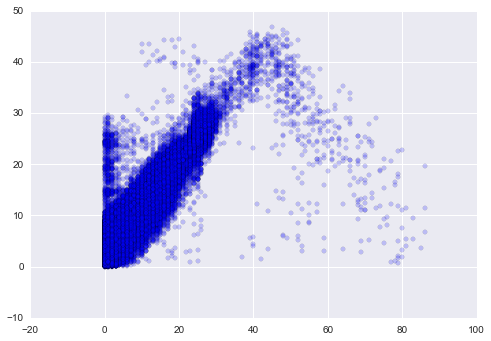

In [46]:
plt.scatter(X.SHOT_DISTANCE,X.SHOT_DIST,alpha=.2)
plt.show()

Although they are pretty similar, we can see that there are some large differences. To try to determine which measure of shot distance is better I looked at the major source of discrepancy: when SHOT_DISTANCE is small but SHOT_DIST is large.

In [48]:
shot_dist=all2013[(X.SHOT_DIST>20)&(X.SHOT_DISTANCE<5)]
shot_dist.head()

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD_x,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,HOME_TEAM_ID,AWAY_TEAM_ID,HOME_PLAYER1_ID,HOME_PLAYER2_ID,HOME_PLAYER3_ID,HOME_PLAYER4_ID,HOME_PLAYER5_ID,AWAY_PLAYER1_ID,AWAY_PLAYER2_ID,AWAY_PLAYER3_ID,AWAY_PLAYER4_ID,AWAY_PLAYER5_ID,ACTION_BEFORE,Unnamed: 0.1,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID.1,LOCATION,MATCHUP,PERIOD_y,PERIOD.1,PTS,PTS_TYPE,SHOT_CLOCK,SHOT_DIST,SHOT_NUMBER,SHOT_RESULT,TOUCH_TIME,W,GRID_TYPE,GAME_EVENT_ID,PLAYER_ID,PLAYER_ID.1,PLAYER_NAME,TEAM_ID,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,off_height,def_height,OFF_HEIGHT,DEF_HEIGHT,HEIGHT_DIFF,SHOT_CLOCK_ADJ,SHOT_CLOCK_REAL,FAST_BREAK_OFF_TURN,JUMP_SHOT
1363,1363,7,1,350,21300009,NaN,NaN,6:35,3,5,5,0,202687,Bismack Biyombo,CHA,Charlotte,1610612766,Bobcats,201177,Josh McRoberts,CHA,Charlotte,1610612766,Bobcats,0,NaN,NaN,NaN,NaN,NaN,53 - 55,-2,Biyombo 1' Dunk (2 PTS) (McRoberts 2 AST),9:38 PM,1610612745,1610612766,2730,202391,201935,202718,201600,202687,201177,201945,202689,203077,1,2,"Harden, James",201935,7.7,0,1,-13,6:40,21300009,A,"OCT 30, 2013 - CHA @ HOU",3,3,2,2,10.2,25.2,3,made,0.5,L,Shot Chart Detail,350,202687,202687,Bismack Biyombo,1610612766,6,35,Made Shot,Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,7,11,1,1,6-9,6-5,81,77,4,395,10.2,0,0
2021,2021,5,2,363,21300013,MISS Splitter 1' Layup,NaN,11:30,4,4,0,0,201168,Tiago Splitter,SAS,San Antonio,1610612759,Spurs,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,10:18 PM,1610612759,1610612763,1938,2588,201158,201168,201988,2034,201144,202347,201573,201585,6,5,"Pondexter, Quincy",202347,4.0,0,0,7,11:34,21300013,H,"OCT 30, 2013 - SAS vs. MEM",4,4,0,2,12.8,21.4,6,missed,0.6,W,Shot Chart Detail,363,201168,201168,Tiago Splitter,1610612759,11,30,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-7,4,1,0,6-11,6-7,83,79,4,690,12.8,0,0
3580,3580,42,2,144,21300023,NaN,NaN,10:24,2,5,0,0,201946,Tyler Hansbrough,TOR,Toronto,1610612761,Raptors,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1,MISS Hansbrough Driving Layup,8:12 PM,1610612737,1610612761,1882,2594,201858,200794,203471,101161,201946,201571,202361,203082,4,1,"Korver, Kyle",2594,5.5,0,0,-7,10:26,21300023,A,"NOV 01, 2013 - TOR @ ATL",2,2,0,2,24.0,21.8,2,missed,0.0,L,Shot Chart Detail,144,201946,201946,Tyler Hansbrough,1610612761,10,24,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-4,1,1,0,6-9,6-7,81,79,2,624,24.0,0,0
3734,3734,42,1,103,21300024,Lee 1' Driving Layup (2 PTS),NaN,1:23,1,4,0,0,201584,Courtney Lee,BOS,Boston,1610612738,Celtics,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,14 - 27,13,NaN,8:05 PM,1610612738,1610612749,201584,101138,201145,202348,203482,203489,203114,2585,203507,203089,3,1,"Antetokounmpo, Giannis",203507,7.3,5,1,-7,1:27,21300024,H,"NOV 01, 2013 - BOS vs. MIL",1,1,2,2,10.0,22.4,2,made,1.8,L,Shot Chart Detail,103,201584,201584,Courtney Lee,1610612738,1,23,Made Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-10,6,1,1,6-5,6-11,77,83,-6,83,10.0,0,0
4022,4022,5,2,4,21300026,MISS Allen 2' Layup,NaN,11:26,1,4,0,5,2754,Tony Allen,MEM,Memphis,1610612763,Grizzlies,0,NaN,NaN,NaN,NaN,NaN,1497,Chauncey Billups,DET,Detroit,1610612765,Pistons,NaN,0,Billups BLOCK (1 BLK),8:14 PM,1610612763,1610612765,2216,2419,2754,201144,201188,1497,101198,2746,20

Looking into these cases and going to the actual play-by-play and watching video of the first shots, in every instance SHOT_DISTANCE is more accurate. This makes sense, as SHOT_DISTANCE is recorded by humans while SHOT_DIST is recorded by the SportVu cameras, and having worked with the cameras themselves I can definitely see how the cameras might lose a player and think a drive to the hoop is a shot. Therefor, I decided to drop SHOT_DIST. Then we can get onto the vizualization of key variables.

In [49]:
X = X.drop('SHOT_DIST', 1)
X_test = X_test.drop('SHOT_DIST', 1)

In [50]:
def vizualize(name,y,cuts):
    x=X[name]
    rang = np.linspace(min(x),max(x),cuts)
    count = []
    pct = []
    for index,val in enumerate(rang):
        if index==cuts-2:
            a=x[(x>=val) & (x<=rang[index+1])]
            b=y[(x>=val) & (x<=rang[index+1])]
            count.append(len(a)/float(len(y)))
            pct.append(sum(b)/float(max(1,len(b)))) 
        elif index<cuts-1:
            a=x[(x>=val) & (x<rang[index+1])]
            b=y[(x>=val) & (x<rang[index+1])]
            count.append(len(a)/float(len(y)))
            pct.append(sum(b)/float(max(1,len(b))))    
    output= list(rang)[0:cuts-1],count,pct
    fig, ax1 = plt.subplots()
    ax1.plot(output[0],output[1],color='b')
    ax1.set_xlabel(name)
    ax1.set_ylabel('Frequency', color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    ax2 = ax1.twinx()
    ax2.plot(output[0],output[2],color='r')
    ax2.set_ylabel('Shooting Percentage', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.suptitle("Exploration of the variable " + name)
    plt.show()

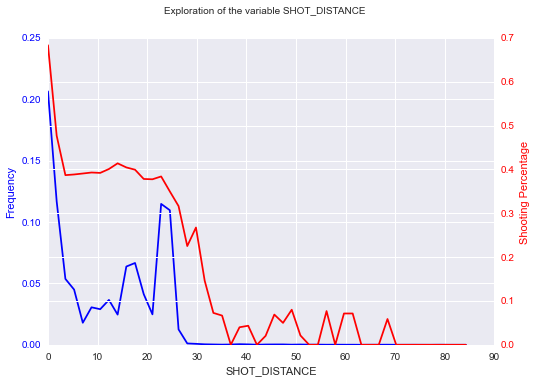

In [52]:
vizualize('SHOT_DISTANCE',y,50)

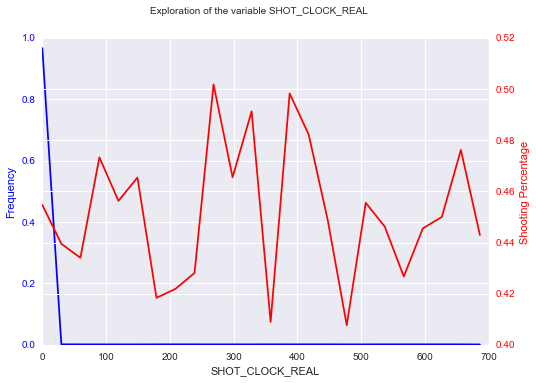

In [54]:
vizualize('SHOT_CLOCK_REAL',y,25)

Woah! That does not look good. This is caused when there is a missing shot clock data, and there is like 500 seconds left in the quarter. We will have to remove those data points to get a better graph. As we can see, those points are very rare so it shouldn't affect our analysis that much.

In [55]:
y=y[X.SHOT_CLOCK_REAL<25]
X=X[X.SHOT_CLOCK_REAL<25]
len(X.index)

194176

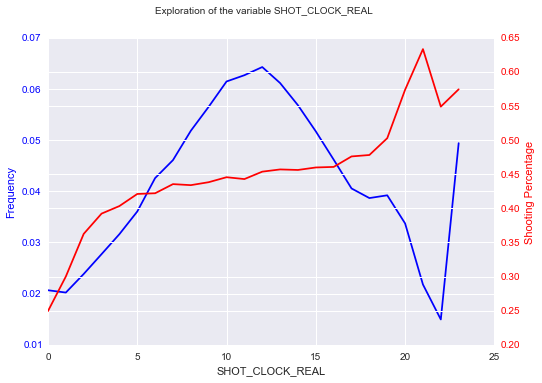

In [56]:
vizualize('SHOT_CLOCK_REAL',y,25)

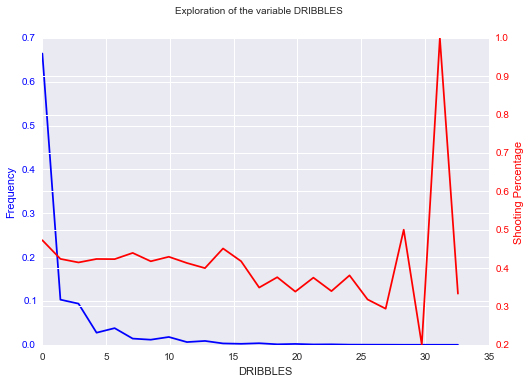

In [57]:
vizualize('DRIBBLES',y,25)

We can see that there is clearly non-linearity for a few of the variables. For that reason, we also created new variables for whether a shot was taken very early, early, middle of the shot clock, or late, since we weren't sure whether the effect of the shot clock was linear. This idea was also taken from [another model](http://nyloncalculus.com/2015/09/28/introducing-kobe-a-measure-of-shot-quality/) on this subject, but we changed up the groupings based on our initial exploration into the data and how shooting percentage varied with shot clock. We also added an indicator variable for whether the shot was a catch-and-shoot opportunity, as there was a small spike when there was 0 dribbles.

After creating these new variables, we also added in dummy variables for the categorical data that we had. This included the period that the game was in, a general shot zone, a general shot range, whether the game was home or away, and the type of shot (dunk, layup, step-back jumper, etc.). We included the dummy variables for general shot location because as we saw in the data exploration phase, the relationship did not seem very linear. 

In [58]:
X_test['CS']=X_test['DRIBBLES']==0
X_test['VERY_EARLY']=X_test.SHOT_CLOCK_REAL>23
X_test['EARLY']=(X_test.SHOT_CLOCK_REAL<=23)&(X_test.SHOT_CLOCK_REAL>18)
X_test['MID']=(X_test.SHOT_CLOCK_REAL<=18)&(X_test.SHOT_CLOCK_REAL>5)
X_test['LATE']=(X_test.SHOT_CLOCK_REAL<=5)
period = pd.get_dummies(all2014['PERIOD_y']).ix[:,1:]
X_test=X_test.join(period)
zonebasic = pd.get_dummies(all2014['SHOT_ZONE_BASIC']).ix[:,1:]
X_test=X_test.join(zonebasic)
shotrange = pd.get_dummies(all2014['SHOT_ZONE_RANGE']).ix[:,1:]
X_test=X_test.join(shotrange)
location = pd.get_dummies(all2014['LOCATION']).ix[:,1:]
X_test=X_test.join(location)
action = pd.get_dummies(all2014['ACTION_TYPE']).ix[:,1:]
X_test=X_test.join(action)

In [59]:
X['CS']=X['DRIBBLES']==0
X['VERY_EARLY']=X.SHOT_CLOCK_REAL>23
X['EARLY']=(X.SHOT_CLOCK_REAL<=23)&(X.SHOT_CLOCK_REAL>18)
X['MID']=(X.SHOT_CLOCK_REAL<=18)&(X.SHOT_CLOCK_REAL>5)
X['LATE']=(X.SHOT_CLOCK_REAL<=5)
period = pd.get_dummies(all2013['PERIOD_y']).ix[:,1:]
X=X.join(period)
zonebasic = pd.get_dummies(all2013['SHOT_ZONE_BASIC']).ix[:,1:]
X=X.join(zonebasic)
shotrange = pd.get_dummies(all2013['SHOT_ZONE_RANGE']).ix[:,1:]
X=X.join(shotrange)
location = pd.get_dummies(all2013['LOCATION']).ix[:,1:]
X=X.join(location)
action = pd.get_dummies(all2013['ACTION_TYPE']).ix[:,1:]
X=X.join(action)

Now we get rid of any columns that have NA values for the regression.

In [60]:
X=X.dropna()
y=y[X.index]

In [18]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

This is the function I will call in the cross validation loop. Notice that it takes two arguments, a distance and an alpha value. The alpha value is straightfoward, it will be used with the l1 penalty when we perform the Lasso regression. The distance is a little more complicated. 

One thing that has been found in previous studies is that it might be good to have two models, one for close shots and one for shots farther away. When we explored how distance related to shooting percentage we can clearly see that shooting percentage decreased pretty linearly until about four feet and then even off for a bit. The idea is that these super close shots interract differently with variables compared to medium and long range shots. Therefor to control for this I create a new dummy variable called CLOSE that is 1 if the shot is taken closer than the specified distance, and 0 if longer. I then create interaction terms for the CLOSE variable and all other variables, incase the interaction between close shots and, say the distance of the closest defender, was different than for medium shots. I considered creating a new model for close shots, rather than just adding a variable, but decided against it as I will a Lasso regression I would be able to tell which variables truly did interact diffently.

In [74]:
def score(alpha,dist):
    X_new=X.copy()
    X_new['CLOSE']=[1 if x<dist else 0 for x in X.SHOT_DISTANCE]
    cols = X.columns
    for col in cols:
        X_new['CLOSEx'+str(col)] = X_new['CLOSE']*X[col]
    lasso = LogisticRegression(penalty='l1',C=alpha)
    err = list()
    err_2 = list()
    kf = KFold(len(y), n_folds=10)
    for tr_idx, tt_idx in kf:
        X_tr , X_tt = X_new.iloc[tr_idx], X_new.iloc[tt_idx]
        y_tr, y_tt = y.iloc[tr_idx], y.iloc[tt_idx]
        lasso.fit(X_tr, y_tr)
        y_hat = lasso.predict(X_tt)
        err.append(lasso.score(X_tt,y_tt))
        err_2.append(np.average((y_hat - y_tt)**2))
    e_alphas = np.average(err)
    e_alphas_r = np.average(err_2)
    return e_alphas,e_alphas_r

I then ran a grid search over various alpha and distance values, searching for the pair that would minimize MSE and accuracy, which I was getting as output from the above function.

Note that the values I use below are only the ones I look at after narrowing the scope down after many iterations. It takes a while to run so that's why I didn't want to run it over every single possible value at once

In [70]:
accuracy={}
dists=[x/2. for x  in range(2,10,1)]
alphas=[1,.1]
for alpha in alphas:
    for dist in dists:
        print (alpha,dist)
        accuracy[(alpha,dist)]=score(alpha,dist)

(1, 2.5)
(1, 3.0)
(1, 3.5)
(1, 4.0)
(1, 4.5)
(0.1, 2.5)
(0.1, 3.0)
(0.1, 3.5)
(0.1, 4.0)
(0.1, 4.5)


In [76]:
import operator
sorted_x = sorted(accuracy.items(), key=operator.itemgetter(1),reverse=True)
sorted_x[:5]

[((0.1, 2.5), (0.65795107537126807, 0.34204892462873199)),
 ((0.1, 3.0), (0.65791804087774541, 0.34208195912225453)),
 ((1, 2.5), (0.65783545676588751, 0.34216454323411244)),
 ((1, 3.0), (0.6578024218176618, 0.3421975781823382)),
 ((0.1, 4.5), (0.65775837395696279, 0.34224162604303715))]

We can now sort these to find the best pair, which turns out to be a distance of 2.5 feet and an alpha of .1. How do we interpret these? For distance, it means that shots within 2.5 feet of the hoop should be treated different than shots farther away than that. How differently? We can look at that later when we look at the coefficients from the regression. The alpha of .1 means that we want a slightly strong penalty, as the alpha is the inverse of regularization strength. Now that we found that alpha and distance that maximize the accuracy and MSE, we can train the model on all the 2013 data and use it predict our 2014 data, to see how well we do.

In [77]:
X_new=X.copy()
X_copy=X.dropna()
X_new=X.dropna()
y=y[X_new.index]
dist=sorted_x[0][0][1]
alpha=sorted_x[0][0][0]
X_new['CLOSE']=[1 if x<dist else 0 for x in X_copy.SHOT_DISTANCE]
cols = X.columns
for col in cols:
    X_new['CLOSEx'+str(col)] = X_new['CLOSE']*X[col]
lasso = LogisticRegression(penalty='l1',C=alpha)
X_test_copy=X_test.dropna()
X_test_new=X_test.dropna()
y_test=y_test[X_test_new.index]
dist=sorted_x[0][0][1]
alpha=sorted_x[0][0][0]
X_test_new['CLOSE']=[1 if x<dist else 0 for x in X_test_copy.SHOT_DISTANCE]
cols = X_test.columns
for col in cols:
    X_test_new['CLOSEx'+str(col)] = X_test_new['CLOSE']*X_test[col]
for missing in list(set(X_new.columns)-set(X_test_new.columns)):
    X_test_new[missing]=0
X_test_new=X_test_new[X_new.columns]
lasso.fit(X_new,y)
print "Training Data (2013) MSE: " + str(np.average((lasso.predict(X_new)-y)**2)) + " and Accuracy: " + str(lasso.score(X_new,y))
print "Test Data (2014) MSE: " + str(np.average((lasso.predict(X_test_new)-y_test)**2)) + " and Accuracy: " + str(lasso.score(X_test_new,y_test))

/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training Data (2013) MSE: 0.341487317554 and Accuracy: 0.658512682446
Test Data (2014) MSE: 0.341796645649 and Accuracy: 0.658203354351


/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now that we have the model trained on the 2014 data, we can take a look what the coefficients of the regression are.

In [79]:
zip(X_new.columns,lasso.coef_[0])

[('SHOT_CLOCK_REAL', 0.014379868318599413),
 ('JUMP_SHOT', -0.83961856806737345),
 ('CLOSE_DEF_DIST', 0.14347694939296407),
 ('DRIBBLES', 0.027168574491446499),
 ('TOUCH_TIME', -0.041996171159707975),
 ('SHOT_DISTANCE', -0.02420123889645184),
 ('HEIGHT_DIFF', 0.028289409259166141),
 ('FAST_BREAK_OFF_TURN', 0.053146573164298876),
 ('SHOT_DISTxCLOSE_DEF_DIST', -0.0047639281948402747),
 ('HEIGHTxCLOSE_DEF_DIST', -0.0039581808828011468),
 ('SHOT_DISTxJUMP_SHOT', 0.045218487930658274),
 ('CS', 0.27507452366357571),
 ('VERY_EARLY', -0.093265813957057714),
 ('EARLY', 0.028153792225686293),
 ('MID', 0.16414555111211779),
 ('LATE', 0.0),
 (1.0, 0.036068732077692171),
 (2.0, 0.0),
 (3.0, 0.050107370708922724),
 (4.0, 0.014895845305069775),
 (5.0, -0.01092285812678755),
 (6.0, 0.0),
 (7.0, 0.0),
 ('Backcourt', -0.031218649626905598),
 ('In The Paint (Non-RA)', 0.080666124981764412),
 ('Left Corner 3', 0.068621275637747836),
 ('Mid-Range', 0.13338304110895957),
 ('Restricted Area', 0.0566175274774

I don't want to go over all the coefficients but I will highlight a few. We have a negative relationship with shot distance and a positive relationship with defender of the closest defender. Shots that are taken very early and very late are both not ideal. Being taller helps you make more shots. Catch and shoot shots are significantly better. Teams at home shoot better. 

Looking at how CLOSE relates, we can see that the variable by itself had a positive coefficient, so close shots go in more than we would normally expect if we thought there was a linear trend between shot distance and shooting percentage. We can see that being more open (having a larger distance from closest defender) matters more for close shots, as does being taller, shots off the break, and taking zero dribbles. 

All of these relationships are pretty much exactly what we would expect, and it is good to confirm them

#Insight: Best Shooters in the NBA

One of the insights I wanted to look at is who the best shooters in the NBA are. One common way of doing this already is looking at points per shot (PPS). Although that is a good measure, it is missing one thing: the difficulty of those shots. For example, DeAndre Jordan has been a league leader in PPS for [the past few seasons](http://espn.go.com/nba/statistics/player/_/stat/field-goals/sort/scoringEfficiency/year/2015), but I can garuntee that no one would consider him an elite scorer in the NBA. Rather, he gets incredibly high percentage looks (alley oops dunks for example) that he converts. This is not a knock on him - if you put a different center at his spot I doubt they would be able to get as good of looks as he does. Yet there is a clear difference between getting high quality looks and converting them at an average rate and getting hard shots but making them at a rate way above average.

In order to explore this distinction, I decided to compute for each player the average difficulty of his shots (as measured by our model) and the average points above average that he scores. We can then look at these numbers to see how they break down, and one simple yet effective vizualization that we can do is to plot them on a scatter plot to see who the outliers are. When doing this, I will limit our area of interest to players that took more than 100 shots, so we have a reasonably sure estimate of their stats. Also, I will be doing this for the 2014 season, although it is also possible to do it for the 2013 season.

In [80]:
var="PLAYER_NAME"
pred=all2014.copy()
pred=pred.iloc[list(X_test_new.index)]
pred['pred']=[x[1] for x in lasso.predict_proba(X_test_new)]
players=list(set(pred[var]))
pred['resid']=(pred.SHOT_MADE_FLAG-pred.pred)*pred.PTS_TYPE
pct_above=[]
predpps=[]
count=[]
players_act=[]
for player in players:
    subset=pred[pred[var]==player]
    if len(subset.index)>100:
        players_act.append(player)
        pct_above.append(np.average(subset.resid))
        predpps.append(np.average(subset.pred*subset.PTS_TYPE))
        count.append(len(subset.index))

We can now look at which players shoot the highest/lowest percentage shots, and which players shoot the most/least above average. I have sorted the players in order from most above average to least above average.

In [84]:
comb=zip(players_act,pct_above,predpps,count)
comb.sort(key=lambda tup: tup[1],reverse=True)
comb

[('Chris Paul', 0.23973377901615528, 0.8518961769309813, 1135),
 ('Luke Babbitt', 0.22491055980561436, 1.035727738066726, 188),
 ('Kyle Korver', 0.20925555660614045, 1.1263726705883519, 581),
 ('Al Jefferson', 0.18426331217935837, 0.7960475686496572, 965),
 ('Hedo Turkoglu', 0.18046329748460122, 1.0260584416458334, 184),
 ('JJ Redick', 0.17042144933245523, 0.9847314385497643, 883),
 ('John Lucas III', 0.16136868119289274, 0.73286208803787645, 104),
 ('Anthony Morrow', 0.16068718789386283, 1.0040382696768526, 601),
 ('Andre Miller', 0.15951348199794943, 0.8621471678215451, 277),
 ('Darren Collison', 0.15625823380048015, 0.90278235660542383, 542),
 ('George Hill', 0.14446295184757929, 0.93393092960557555, 523),
 ('Carl Landry', 0.13982233082392206, 0.90990142608215518, 362),
 ('Hassan Whiteside', 0.11695869038241889, 1.1441524207286922, 360),
 ('Mike Muscala', 0.11406497205334402, 1.063239992485663, 141),
 ('Isaiah Thomas', 0.11306777685327568, 0.91539276648436996, 773),
 ('Damjan Rudez'

We can also plot these values on a scatter plot, with points above predicted on the x axis and expected points per shot on the y axis. I have also added in a line that tracks what a player's expected points per shot would have to be in order to be average given their points above average score. The interpretation of this is players above the line shoot score more points per shot than average.

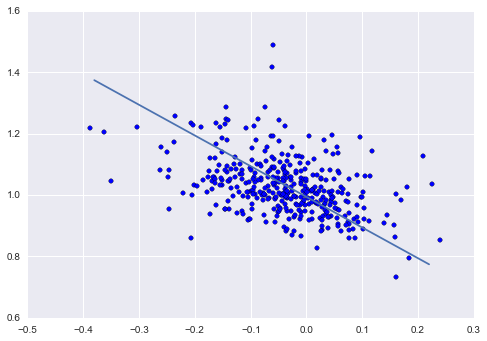

In [86]:
mean=np.average(pred.PTS_TYPE*pred.SHOT_MADE_FLAG)
pts=[x/100. for x in range(int(100*min(pct_above)),int(100*max(pct_above)),1)]
val=[]
for pt in pts:
    val.append(mean-pt)
plt.scatter(pct_above,predpps)
plt.plot(pts,val)

We can also do the same for teams.

In [88]:
var="PLAYER1_TEAM_NICKNAME"
pred=all2014.copy()
pred=pred.iloc[list(X_test_new.index)]
pred['pred']=[x[1] for x in lasso.predict_proba(X_test_new)]
players=list(set(pred[var]))
pred['resid']=(pred.SHOT_MADE_FLAG-pred.pred)*pred.PTS_TYPE
pct_above=[]
predpps=[]
count=[]
players_act=[]
for player in players:
    subset=pred[pred[var]==player]
    if len(subset.index)>100:
        players_act.append(player)
        pct_above.append(np.average(subset.resid))
        predpps.append(np.average(subset.pred*subset.PTS_TYPE))
        count.append(len(subset.index))

In [90]:
comb_team=zip(players_act,pct_above,predpps,count)
comb_team.sort(key=lambda tup: tup[2],reverse=True)
comb_team

[('Warriors', -0.068974717471251418, 1.1498313608278949, 6864),
 ('Rockets', -0.069245371053334462, 1.0979845552313321, 6472),
 ('Mavericks', -0.061694538172112026, 1.0878325704775453, 6810),
 ('Hawks', -0.028001869530939794, 1.0850833487391645, 6517),
 ('Lakers', -0.11314220290754765, 1.0592891829730042, 6722),
 ('Raptors', -0.038092681077099608, 1.0539369545039896, 6627),
 ('Thunder', -0.046183830908420605, 1.040173312501208, 6655),
 ('Cavaliers', 0.0050122832805287853, 1.0389914353435803, 6454),
 ('Trail Blazers', -0.0124616673052444, 1.0272862673346002, 6813),
 ('Nuggets', -0.054601369782415587, 1.0264132479856112, 6634),
 ('Spurs', 0.0051445387651714563, 1.0246280524975455, 6684),
 ('Magic', -0.043537052317727996, 1.0239021389874625, 6519),
 ('Bucks', -0.024681750216936676, 1.0216048271400138, 6175),
 ('Grizzlies', -0.035499710877190976, 1.0121330698318414, 6505),
 ('Clippers', 0.056235242699932408, 1.0119752172874652, 6348),
 ('Celtics', -0.020749735265797504, 1.0054509076993119,

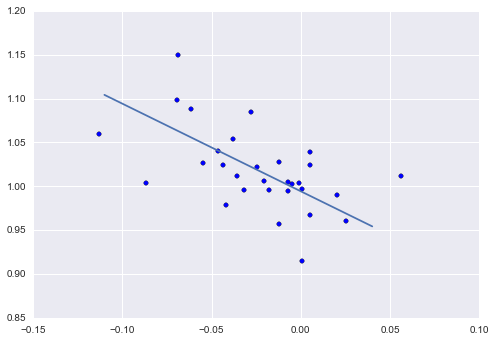

In [91]:
mean=np.average(pred.PTS_TYPE*pred.SHOT_MADE_FLAG)
pts=[x/100. for x in range(int(100*min(pct_above)),int(100*max(pct_above)),1)]
val=[]
for pt in pts:
    val.append(mean-pt)
plt.scatter(pct_above,predpps)
plt.plot(pts,val)

How do these results look? Not going to lie, they look a little suspicious. I first noticed this when looking at the team results. The fact that a team like Golden State, perhaps thought of as the best shooting team in the NBA, is well below average is a little suspicious. Looking at the their players, again we see something weird: Stephen Curry, perhaps the best shooter in the history of the NBA, is barely above average. How is this happening?

Looking at the coefficients we can see something weird: despite the fact that the model hates jump shots, penalizing them heavily, it actually has a positive coefficient for pullup jump shots. In theory, a pullup jump shot is harder since you can't really set your feet. If there was a small difference than maybe its just that other variables explain it better, but the difference in coefficients is fairly large. So why is this the case?

Looking at Stephen Curry below, we can see he shoots an inordinate amount of pullup jump shots, and that he makes up a much larger percentage of shots that are pullup jump shots than is normal.

In [103]:
pull_up_steph = all2013[(all2013.ACTION_TYPE=="Pullup Jump shot") & (all2013.PLAYER_NAME=='Stephen Curry')]
steph = all2013[(all2013.PLAYER_NAME=='Stephen Curry')]
pull_up = all2013[(all2013.ACTION_TYPE=="Pullup Jump shot")]
print "Percentage of Stephen Curry's shots that are Pullup Jump shots: " + str(len(pull_up_steph.index)/float(len(steph.index)))
print "Percentage of all shots that are Pullup Jump shots: " + str(len(pull_up.index)/float(len(all2013.index)))
print "Percentage of all Pullup Jump shots that are shot by Stephen Curry: " + str(len(pull_up_steph.index)/float(len(pull_up.index)))

Percentage of Stephen Curry's shots that are Pullup Jump shots: 0.191553544495
Percentage of all shots that are Pullup Jump shots: 0.0326577529197
Percentage of all Pullup Jump shots that are shot by Stephen Curry: 0.0387018131952


Looking at the players who shoot the most pullup jumpers, we can see that some of the best shooters in the NBA are represented. This makes sense: pullup jumpers mean that the player has been dribbling the ball and is shooting from distance - most of the players who have the green light to pull up from far and shoot are very good, as evidenced by this list before. 

In [97]:
from collections import Counter
Counter(list(pull_up.PLAYER_NAME)).most_common(10)

[('Klay Thompson', 264),
 ('Russell Westbrook', 252),
 ('Stephen Curry', 249),
 ('Monta Ellis', 153),
 ('Harrison Barnes', 115),
 ('Chris Paul', 113),
 ('John Wall', 111),
 ('Draymond Green', 109),
 ('Kyle Lowry', 105),
 ('Beno Udrih', 102)]

What is going on, I believe, is that this certain type of shot (and perhaps others) is acting as a signaling mechanism for the player who is shooting being good. Therefor, the model is not capturing pure shot difficulty but rather is also incorporating some information of how good the player is. Although that may not be a problem is I was just trying to predict whether a shot would go in, it is if I am trying to measure shot difficulty. So how to fix this?

Ideally, I would do mixed effects model. However, this is where Python comes up short compared to R - it doesn't have very good modules to do this. Infact, it doesn't have ANY mixed effect module for logistic models - they only [just added one for regular linear regression](https://www.reddit.com/r/pystats/comments/34cgeb/mixedeffects_logistic_regression_in_python/). 

To get around this, I will basically manufacture a mixed effects model. Although not exactly same, a good estimate of this is is subset the data by player and then run a regression on each player's shots. By then averaging the coefficients, we can estimate the model for the hypothetical average player, which will give us a measure of shot difficulty. 

In [138]:
main=X_new.copy()
clf=LogisticRegression(penalty='l1',C=.1)
coefs=list(np.repeat(0,166))
main['PLAYER_NAME']=all2013.iloc[main.index].PLAYER_NAME
players=set(list(main.PLAYER_NAME))
n=0
for index,player in enumerate(players):
    ind=main[main.PLAYER_NAME==player]
    y_ind=y[main.PLAYER_NAME==player]
    if (np.average(y_ind)!=0) & (np.average(y_ind)!=1) & (len(y.index)>0):
        n+=1
        ind=ind.drop('PLAYER_NAME',axis=1)
        clf.fit(ind,y_ind)
        mod=list(clf.intercept_)+list(clf.coef_[0])
        coefs=[x+z for x,z in zip(mod,coefs)]


In [139]:
coefs_mean=[x/float(n) for x in coefs][1:]
intercept = coefs[0]/float(n)

In [140]:
zip(coefs_mean,main.columns)

[(3.1351901426356524e-05, 'SHOT_CLOCK_REAL'),
 (-0.038660662615457968, 'JUMP_SHOT'),
 (0.027701265851567618, 'CLOSE_DEF_DIST'),
 (-0.013386324365660727, 'DRIBBLES'),
 (-0.040496482008828598, 'TOUCH_TIME'),
 (-0.0097683529702461691, 'SHOT_DISTANCE'),
 (0.018859822248252493, 'HEIGHT_DIFF'),
 (0.0, 'FAST_BREAK_OFF_TURN'),
 (0.00029301078360015526, 'SHOT_DISTxCLOSE_DEF_DIST'),
 (-0.00073486203982816515, 'HEIGHTxCLOSE_DEF_DIST'),
 (-0.041313062364197475, 'SHOT_DISTxJUMP_SHOT'),
 (0.0086242817426296081, 'CS'),
 (0.0, 'VERY_EARLY'),
 (0.00036990660405297526, 'EARLY'),
 (0.0073959175591452094, 'MID'),
 (-0.0011823864757287044, 'LATE'),
 (-0.00024752504031618926, 1.0),
 (-0.00065801937675415471, 2.0),
 (0.00048772446642053125, 3.0),
 (-0.001284278508168197, 4.0),
 (0.0, 5.0),
 (0.0, 6.0),
 (0.0, 7.0),
 (0.0, 'Backcourt'),
 (-0.0053668482038232417, 'In The Paint (Non-RA)'),
 (0.0, 'Left Corner 3'),
 (0.00070515848723998599, 'Mid-Range'),
 (0.0012645425198513618, 'Restricted Area'),
 (7.824998017

Looking at the coefficients above, we can see that Pullup jumpers is now much closer to regular jumpers. It still isn't compeletely below, probably because only certain players take pull up jump shots so the coefficient for all those will be zero. Do the results we get make anymore sense? Let's look at who this model says the best shooters are for the 2014 season.

In [108]:
def calc_row(row):
    z = intercept + sum([x*q for x,q in zip(row,coefs_mean)])
    return np.exp(z)/(1+np.exp(z))

In [141]:
main=X_test_new.copy()
main['PLAYER_NAME']=all2014.iloc[main.index].PLAYER_NAME
est=main.apply(calc_row,axis=1)

In [142]:
main['pred']=est
predictions = [1 if x>.5 else 0 for x in est]
np.mean(predictions==y_test)

0.63233860056671687

In [145]:
var="PLAYER_NAME"
pred=main
pred['PTS_TYPE']=all2014.iloc[main.index]['PTS_TYPE']
pred[var]=all2014.iloc[main.index][var]
players=list(set(pred[var]))
pred['resid']=(y_test-pred.pred)*pred.PTS_TYPE
pct_above=[]
predpps=[]
count=[]
players_act=[]
for player in players:
    subset=pred[pred[var]==player]
    if len(subset.index)>100:
        players_act.append(player)
        pct_above.append(np.average(subset.resid))
        predpps.append(np.average(subset.pred*subset.PTS_TYPE))
        count.append(len(subset.index))

In [146]:
comb=zip(players_act,pct_above,predpps,count)
comb.sort(key=lambda tup: tup[1],reverse=True)
comb

[('Kyle Korver', 0.57711567868077707, 0.75851254851371519, 581),
 ('Chris Paul', 0.45123741803037476, 0.64039253791676176, 1135),
 ('Luke Babbitt', 0.41721460310979513, 0.8434236947625452, 188),
 ('JJ Redick', 0.41286826350478972, 0.74228462437742992, 883),
 ('Hedo Turkoglu', 0.40511954968794939, 0.80140218944248542, 184),
 ('Damjan Rudez', 0.3851105055444774, 0.78412026368629184, 260),
 ('Anthony Morrow', 0.38041387227562168, 0.78431158529509371, 601),
 ('Jason Terry', 0.3543828595486625, 0.76825864988529979, 424),
 ('Darren Collison', 0.33641317303779117, 0.72262741736811287, 542),
 ('George Hill', 0.3284343745557024, 0.7499595068974525, 523),
 ('Isaiah Canaan', 0.32415658128994684, 0.72847499765742163, 342),
 ('John Lucas III', 0.32253513773196008, 0.57169563149880909, 104),
 ('Isaiah Thomas', 0.31393677427613648, 0.71452376906150905, 773),
 ('CJ Watson', 0.31338028833524656, 0.73796445494103713, 409),
 ('Caron Butler', 0.3115783698665634, 0.7065563451593434, 386),
 ('Stephen Curry'

In [152]:
player_stats = pd.DataFrame(comb)
player_stats.columns=["Name","Points Above Expected","Expected Points", "Count"]
player_stats.to_excel('player_stats.xlsx')

Doing the same for teams:

In [147]:
var="PLAYER1_TEAM_NICKNAME"
pred=main
pred['PTS_TYPE']=all2014.iloc[main.index]['PTS_TYPE']
pred[var]=all2014.iloc[main.index][var]
players=list(set(pred[var]))
pred['resid']=(y_test-pred.pred)*pred.PTS_TYPE
pct_above=[]
predpps=[]
count=[]
players_act=[]
for player in players:
    subset=pred[pred[var]==player]
    if len(subset.index)>100:
        players_act.append(player)
        pct_above.append(np.average(subset.resid))
        predpps.append(np.average(subset.pred*subset.PTS_TYPE))
        count.append(len(subset.index))

In [155]:
comb_teams=zip(players_act,pct_above,predpps,count)
comb_teams.sort(key=lambda tup: tup[1],reverse=True)
comb_teams

[('Clippers', 0.23981010214690382, 0.82840035784049382, 6348),
 ('Cavaliers', 0.18522907374269448, 0.85877464488141453, 6454),
 ('Hawks', 0.18327236689632737, 0.87380911231189728, 6517),
 ('Trail Blazers', 0.16349194390252075, 0.85133265612683484, 6813),
 ('Spurs', 0.15814143248781251, 0.87163115877490438, 6684),
 ('Mavericks', 0.1502573342823342, 0.87588069802309898, 6810),
 ('Raptors', 0.14825244818410263, 0.86759182524278733, 6627),
 ('Nets', 0.1458648615801047, 0.85120830915160262, 6150),
 ('Suns', 0.14411361348610033, 0.85883754484354402, 6777),
 ('Pacers', 0.14334325970370981, 0.82907788916113867, 6563),
 ('Wizards', 0.14263589820018555, 0.8547663022888119, 6544),
 ('Heat', 0.14199804950862246, 0.85551315009316942, 6027),
 ('Celtics', 0.13876653742385514, 0.84593463500965937, 6994),
 ('Pelicans', 0.13037052993076303, 0.8801706909628807, 6356),
 ('Knicks', 0.12568583774690065, 0.81867935483512511, 6309),
 ('Warriors', 0.1190853126982294, 0.9617713306584138, 6864),
 ('Bucks', 0.118

In [156]:
team_stats = pd.DataFrame(comb_teams)
team_stats.columns=["Name","Points Above Expected","Expected Points", "Count"]
team_stats.to_excel('team_stats.xlsx')

This looks better. Stephen Curry is near the top of the list in terms of shooting above expected, and team-wise the Warriors are in the middle. This does seem a little low, but they also have the highest expected points, so it seems like they are getting most of the points through great ball movement and getting great looks.

Is this model significantly worse at predicting shots than the other one? Not really. We can see our accuracy is above 63%, about 2% worse than the previous version.

In [149]:
predictions = [1 if x>.5 else 0 for x in est]
print "Accuracy of new model: " + str(np.mean(predictions==y_test))

Accuracy of new model: 0.632338600567


In [439]:
from sklearn.metrics import accuracy_score

In [555]:
predictions = [1 if x>.5 else 0 for x in est]
len(predictions)

187951

In [552]:
np.mean(np.sqrt((est - y_new)**2))

0.48068614926905778

In [557]:
np.mean(predictions == y_new)

0.61461763970396543

In [669]:
def cv_alpha(alpha):
    main=X_new.copy()
    main['PLAYER_NAME']=all2013.iloc[main.index].PLAYER_NAME
    kf=KFold(len(y_new), n_folds=2)
    err_mse=list()
    for tr_idx, tt_idx in kf:
        clf=LogisticRegression(penalty='l1',C=alpha)
        X_tr , X_tt = main.iloc[tr_idx], main.iloc[tt_idx]
        y_tr, y_tt = y_new.iloc[tr_idx], y_new.iloc[tt_idx]
        coefs=list(np.repeat(0,166))
        players=set(list(X_tr.PLAYER_NAME))
        n=0
        for index,player in enumerate(players):
            huh=X_tr[X_tr.PLAYER_NAME==player]
            y_huh=y_tr[X_tr.PLAYER_NAME==player]
            if (np.average(y_huh)!=0) & (np.average(y_huh)!=1)&(not huh.isnull().values.any()):
                n+=1
                huh=huh.drop('PLAYER_NAME',axis=1)
                clf.fit(huh,y_huh)
                mod=list(clf.intercept_)+list(clf.coef_[0])
                coefs=[x+z for x,z in zip(mod,coefs)]
        coefs_mean=[x/float(n) for x in coefs][1:]
        intercept = coefs[0]/float(n)
        def calc_row(row):
            z = intercept + sum([x*q for x,q in zip(row,coefs_mean)])
            return np.exp(z)/(1+np.exp(z))
        est=X_tt.apply(calc_row,axis=1)
        print est[0:1]
        err_mse.append(np.mean((est - y_tt)**2))
    return np.average(err_mse)

In [697]:
mse={}
alphas=[.2,.3,.5,.4]
for alpha_1 in alphas:
    mse[alpha_1]=cv_alpha(alpha_1)

0    0.363477
dtype: float64
101075    0.249142
dtype: float64
0    0.32455
dtype: float64
101075    0.235622
dtype: float64
0    0.277388
dtype: float64
101075    0.211686
dtype: float64
0    0.2974
dtype: float64
101075    0.225787
dtype: float64


In [698]:
mse

{0.2: 0.23676984431616915,
 0.3: 0.23614260757073519,
 0.4: 0.23663584131945467,
 0.5: 0.23737313175230701}

In [653]:
cv_alpha(.001)

0    0.178625
dtype: float64
101075    0.123318
dtype: float64


0.41252952254019115

In [623]:
main=X_new.copy()
main['PLAYER_NAME']=all2013.iloc[main.index].PLAYER_NAME

kf=KFold(len(y_new), n_folds=2)


In [624]:
clf=LogisticRegression(penalty='l1',C=1)
err_mse=[]
for tr_idx, tt_idx in kf:
    X_tr , X_tt = main.iloc[tr_idx], main.iloc[tt_idx]
    y_tr, y_tt = y_new.iloc[tr_idx], y_new.iloc[tt_idx]
    coefs=list(np.repeat(0,166))
    players=set(list(X_tr.PLAYER_NAME))
    n=0
    for index,player in enumerate(players):
        huh=X_tr[X_tr.PLAYER_NAME==player]
        y_huh=y_tr[X_tr.PLAYER_NAME==player]
        if (np.average(y_huh)!=0) & (np.average(y_huh)!=1)&(not huh.isnull().values.any()):
            n+=1
            huh=huh.drop('PLAYER_NAME',axis=1)
            clf.fit(huh,y_huh)
            mod=list(clf.intercept_)+list(clf.coef_[0])
            coefs=[x+z for x,z in zip(mod,coefs)]
    coefs_mean=[x/float(n) for x in coefs][1:]
    intercept = coefs[0]/float(n)
    est=X_tt.apply(calc_row,axis=1)
    err_mse.append(np.mean(np.sqrt((est - y_tt)**2)))

In [608]:
err_mse

[0.42464349691951547, 0.41737562893706215]

In [606]:
err_mse

[0.49568800573823013, 0.49561596115934975]

In [712]:
ids = list(set(all2013.HOME_PLAYER1_ID+all2013.HOME_PLAYER2_ID+all2013.HOME_PLAYER3_ID+all2013.HOME_PLAYER4_ID+all2013.HOME_PLAYER5_ID+all2013.AWAY_PLAYER1_ID+all2013.AWAY_PLAYER2_ID+all2013.AWAY_PLAYER3_ID+all2013.AWAY_PLAYER4_ID+all2013.AWAY_PLAYER5_ID))

In [713]:
ids_non=[x for x in ids if str(x)!="nan"]

In [718]:
def players(a):
    url = "http://stats.nba.com/stats/commonallplayers?"
    api_param = {'IsOnlyCurrentSeason':"0",
                          'LeagueID': '00',
                          'Season': '2015-16'}
    pull = requests.get(url, params=api_param)
    _headers = pull.json()['resultSets'][0]['headers']
    _values = pull.json()['resultSets'][0]['rowSet']
    season=pd.DataFrame([dict(zip(_headers, value)) for value in _values])
    season = season.query("FROM_YEAR <= @a and TO_YEAR >= @a")
    return season

In [719]:
players2013=players('2013')

In [814]:
je=all2013.copy()
huh=je['HOME_PLAYER1_ID']
huh=huh.dropna()
je=je.loc[huh.index]

In [815]:
je['Home']=[[int(x),int(y),int(z),int(w),int(s)] for x,y,z,w,s in zip(je.HOME_PLAYER1_ID,je.HOME_PLAYER2_ID,je.HOME_PLAYER3_ID,je.HOME_PLAYER4_ID,je.HOME_PLAYER5_ID)]
je['Away']=[[int(x),int(y),int(z),int(w),int(s)] for x,y,z,w,s in zip(je.AWAY_PLAYER1_ID,je.AWAY_PLAYER2_ID,je.AWAY_PLAYER3_ID,je.AWAY_PLAYER4_ID,je.AWAY_PLAYER5_ID)]
je['OFF_all']=[x if z=='H' else y for x,y,z in zip(je.Home,je.Away,je.LOCATION)]
je['DEF']=[map(str,y) if z=='H' else map(str,x) for x,y,z in zip(je.Home,je.Away,je.LOCATION)]
je['OFF'] = [[str(z) for z in x if z!=y] for x,y in zip(je.OFF_all,je.PLAYER_ID)]

In [816]:
je.head()

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD_x,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,HOME_TEAM_ID,AWAY_TEAM_ID,HOME_PLAYER1_ID,HOME_PLAYER2_ID,HOME_PLAYER3_ID,HOME_PLAYER4_ID,HOME_PLAYER5_ID,AWAY_PLAYER1_ID,AWAY_PLAYER2_ID,AWAY_PLAYER3_ID,AWAY_PLAYER4_ID,AWAY_PLAYER5_ID,ACTION_BEFORE,Unnamed: 0.1,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID.1,LOCATION,MATCHUP,PERIOD_y,PERIOD.1,PTS,PTS_TYPE,SHOT_CLOCK,SHOT_DIST,SHOT_NUMBER,SHOT_RESULT,TOUCH_TIME,W,GRID_TYPE,GAME_EVENT_ID,PLAYER_ID,PLAYER_ID.1,PLAYER_NAME,TEAM_ID,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,off_height,def_height,OFF_HEIGHT,DEF_HEIGHT,HEIGHT_DIFF,SHOT_CLOCK_ADJ,SHOT_CLOCK_REAL,FAST_BREAK_OFF_TURN,Home,Away,OFF_all,DEF,OFF
0,0,1,2,2,21300001,MISS West 6' Jump Shot,NaN,11:39,1,4,0,0,2561,David West,IND,Indiana,1610612754,Pacers,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,7:12 PM,1610612754,1610612753,2561,201579,201588,202331,202362,2749,101131,201167,202696,203090,10,0,"Maxiell, Jason",101131,1.6,2,0,10,11:41,21300001,H,"OCT 29, 2013 - IND vs. ORL",1,1,0,2,6.7,7.4,1,missed,7.8,W,Shot Chart Detail,2,2561,2561,David West,1610612754,11,39,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,-38,45,1,0,6-9,6-7,81,79,2,699,6.7,0,"[2561, 201579, 201588, 202331, 202362]","[2749, 101131, 201167, 202696, 203090]","[2561, 201579, 201588, 202331, 202362]","[2749, 101131, 201167, 202696, 203090]","[201579, 201588, 202331, 202362]"
1,1,79,1,5,21300001,George 19' Pullup Jump Shot (2 PTS),NaN,11:30,1,4,0,0,202331,Paul George,IND,Indiana,1610612754,Pacers,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0 - 2,2,NaN,7:13 PM,1610612754,1610612753,2561,201579,201588,202331,202362,2749,101131,201167,202696,203090,6,0,"Harkless, Maurice",203090,4.1,1,1,10,11:32,21300001,H,"OCT 29, 2013 - IND vs. ORL",1,1,2,2,16.8,19.3,1,made,3.2,W,Shot Chart Detail,5,202331,202331,Paul George,1610612754,11,30,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,19,105,164,1,1,6-9,6-9,81,81,0,690,16.8,0,"[2561, 201579, 201588, 202331, 202362]","[2749, 101131, 201167, 202696, 203090]","[2561, 201579, 201588, 202331, 202362]","[2749, 101131, 201167, 202696, 203090]","[2561, 201579, 201588, 202362]"
2,2,1,2,6,21300001,NaN,NaN,11:15,1,5,0,0,201167,Arron Afflalo,ORL,Orlando,1610612753,Magic,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,-2,MISS Afflalo 27' 3PT Jump Shot,7:13 PM,1610612754,1610612753,2561,201579,201588,202331,202362,2749,101131,201167,202696,203090,1,0,"George, Paul",202331,4.4,0,0,-10,11:18,21300001,A,"OCT 29, 2013 - ORL @ IND",1,1,0,3,13.0,24.5,1,missed,0.7,L,Shot Chart Detail,6,201167,201167,Arron Afflalo,1610612753,11,15,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27,51,266,1,0,6-5,6-9,77,81,-4,675,13.0,0,"[2561, 201579, 201588, 202331, 202362]","[2749, 101131, 201167, 202696, 203090]","[2749, 101131, 201167, 202696, 203090]","[2561, 201579, 201588, 202331, 202362]","[2749, 101131, 202696, 203090]"
3,3,5,2,8,21300001,MISS West 3' Layup,NaN,11:03,1,4,0,5,2561,David West,IND,Indiana,1610612754,Pacers,0,NaN,NaN,NaN,NaN,NaN,101131,Jason Maxiell,ORL,Orlando,1610612753,Magic,NaN,2,Maxiell BLOCK (1 BLK),7:13 PM,1610612754,1610612753,2561,201579,201588,202331,202362,2749,101131,201167,202696,203090,4,1,"Maxiell, Jason",101131,0.4,0,0,10,11:05,21300001,H,"OCT 29, 2013 - IND vs. ORL"

In [818]:
off=je['OFF'].str.join(sep='*').str.get_dummies(sep='*')
deff=je['DEF'].str.join(sep='*').str.get_dummies(sep='*')

In [876]:
shoot=pd.get_dummies(map(int,map(float,je['SHOOTER'])))

In [823]:
off.columns ='off' + off.columns.astype(str)
deff.columns ='def' + deff.columns.astype(str)

In [878]:
shoot.columns='shoot' + shoot.columns.astype(str)

In [829]:
je=je.join(off)
je=je.join(deff)

In [879]:
je=je.join(shoot)

In [832]:
main["PRED_PTS"]=main.pred*main.PTS_TYPE


In [880]:
list(je.columns)[100:]

['SHOOTER',
 'off101106',
 'off101107',
 'off101108',
 'off101109',
 'off101110',
 'off101111',
 'off101112',
 'off101114',
 'off101115',
 'off101122',
 'off101123',
 'off101126',
 'off101127',
 'off101128',
 'off101131',
 'off101133',
 'off101135',
 'off101138',
 'off101139',
 'off101141',
 'off101142',
 'off101145',
 'off101150',
 'off101154',
 'off101155',
 'off101161',
 'off101162',
 'off101179',
 'off101181',
 'off101183',
 'off101187',
 'off101198',
 'off101236',
 'off101249',
 'off1495',
 'off1497',
 'off1536',
 'off1712',
 'off1713',
 'off1717',
 'off1718',
 'off1733',
 'off1737',
 'off1740',
 'off1882',
 'off1889',
 'off1890',
 'off1891',
 'off1897',
 'off1905',
 'off1938',
 'off200745',
 'off200746',
 'off200751',
 'off200752',
 'off200755',
 'off200756',
 'off200757',
 'off200758',
 'off200761',
 'off200765',
 'off200768',
 'off200769',
 'off200770',
 'off200777',
 'off200779',
 'off200780',
 'off200782',
 'off200794',
 'off200797',
 'off200811',
 'off200826',
 'off200839',


In [881]:
x_r = je[list(je.columns)[101:]]
y_r=main.loc[je.index]["PRED_PTS"]

In [882]:
huh=y_r.dropna()
x_r=x_r.loc[huh.index]
y_r=huh

In [884]:
huh=x_r.dropna()
y_r=y_r.loc[huh.index]
x_r=huh

In [885]:
len(x_r)

128527

In [900]:
from sklearn.linear_model import Ridge
clf=Ridge(alpha=20)
clf.fit(x_r,y_r)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [901]:
huh=zip(x_r.columns,clf.coef_)
huh=sorted(huh,key=lambda x: x[1])

In [907]:
huh[-100:]

[('off101114', 0.0633311970402647),
 ('off202323', 0.063768264765887303),
 ('off201228', 0.064038906675665488),
 ('off203477', 0.064528358188851206),
 ('off101126', 0.064550746448463134),
 ('shoot202933', 0.064950380628996787),
 ('off203116', 0.06501736790923332),
 ('off203539', 0.065159787650605289),
 ('def203540', 0.065180281898281719),
 ('off2749', 0.065492003877641813),
 ('off203517', 0.065587733380062907),
 ('off1713', 0.065588370379695574),
 ('off201609', 0.065690865423257652),
 ('off202708', 0.065708299792929553),
 ('off203079', 0.065816085074802716),
 ('off2594', 0.066281715334809796),
 ('off202390', 0.066290764171121133),
 ('off201596', 0.066546753769488529),
 ('off1889', 0.066739960911095839),
 ('off101127', 0.067188662791241166),
 ('off201573', 0.06770448379104449),
 ('off201952', 0.068130796559223494),
 ('off2581', 0.070019237258933678),
 ('off203548', 0.070739027023418097),
 ('off202397', 0.07116382497210566),
 ('off201979', 0.071941896001861405),
 ('off203487', 0.07194986